# Classification model on a MCU NN Library

In [2]:
import os

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch import nn
import torch
from torch2cmsis import converter

from mcu.utils import transform_cifar10, sample_from_class, SimpleTrainer

## Dataset

First, we load the dataset and split it in training, validation, and test.

In [3]:
train_set = CIFAR10(
    root="./data/data_cifar10/",
    train=True,
    transform=transform_cifar10(),
    download=True
    )
val_set, tr_set = sample_from_class(train_set, 500)
test_set = CIFAR10(
    root="./data/data_cifar10/",
    train=False,
    transform=transform_cifar10(),
    download=True
    )

Files already downloaded and verified
Files already downloaded and verified


Then we can build the dataloaders with batch size 8

In [4]:
batch_size = 8
datasets = [tr_set, val_set, test_set]
dataloaders = {
    i: DataLoader(
        sett, batch_size=8, shuffle=True, num_workers=4
    )
    for i, sett in zip(["train", "val", "test"], datasets)
}

## Network

We can now build our network

In [5]:
class SampleCNN(nn.Module):
    def __init__(self, shape=(3, 32, 32), batch_size=4):
        super().__init__()
        self.input_shape = shape
        self.batch_size = batch_size

        self.conv1 = nn.Conv2d(in_channels=shape[0], out_channels=64, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3)
        self.pool2 = nn.AvgPool2d(2)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3)
        self.pool3 = nn.AvgPool2d(2)
        self.relu3 = nn.ReLU()

        self.flatten = nn.Flatten()
        self.interface_shape = self.get_shape()
        self.interface = nn.Linear(in_features=self.interface_shape.numel(), out_features=10)

    def get_shape(self):
        sample = torch.randn(size=(self.batch_size, *self.input_shape)).type_as(self.conv1.weight)
        out = self.conv1(sample)
        out = self.pool1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.pool2(out)
        out = self.relu2(out)
        out = self.conv3(out)
        out = self.pool3(out)
        out = self.relu3(out)
        return out.shape[1:]

    def forward(self, x):
        out = self.conv1(x)
        out = self.pool1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.pool2(out)
        out = self.relu2(out)
        out = self.conv3(out)
        out = self.pool3(out)
        out = self.relu3(out)
        out = self.flatten(out)
        return self.interface(out)


Let's declare the network

In [6]:
input_shape = (3, 32, 32)
cnn = SampleCNN(shape=input_shape, batch_size=8)

## Train

Let's train, but before let's declare the trainer and the training hyperparameters

In [7]:
trainer = SimpleTrainer(datasets=datasets, dataloaders=dataloaders)

In [8]:
hyperparam = {
    "learning_rate": 0.001,
    "learning_step": 5000,
    "learning_gamma": 0.99,
    "epochs": 2,
}

In [9]:
cnn = trainer.train(cnn, hyperparam, "cnn_model")

Validation accuracy 0.558: 100%|██████████| 2/2 [00:30<00:00, 15.03s/it]


## Evaluate

We set now the network to evaluation mode and evaluate it on the test set

In [10]:
cnn.eval()
accuracy_test = trainer.evaluate(cnn)

In [11]:
print("Accuracy for test set with PyTorch ", accuracy_test)

Accuracy for test set with PyTorch  0.5548


## COnvert to CMSIS-NN

Let's convert it to CMSIS with the CMSIS converter.

In [17]:
conversion_config = {
    "compilation": "gcc -g -I../../../CMSIS_5/CMSIS/Core/Include \
            -I../../../CMSIS_5/CMSIS/DSP/Include \
            -I../../../CMSIS_5/CMSIS/NN/Include \
            -D__ARM_ARCH_8M_BASE__ \
            ../../../CMSIS_5/CMSIS/NN/Source/*/*.c \
            ../../../CMSIS_5/CMSIS/DSP/Source/StatisticsFunctions/arm_max_q7.c \
            main.c -o main",
    "exec_path": "main",
        }
os.makedirs("cfiles", exist_ok=True)

In [18]:
from importlib import reload 
reload(converter)

<module 'torch2cmsis.converter' from '/home/blue/miniconda3/envs/course/lib/python3.8/site-packages/torch2cmsis/converter.py'>

In [19]:
cm_converter = converter.CMSISConverter(
    root="cfiles",
    model=cnn,
    weight_file_name="weights.h",
    parameter_file_name="parameters.h",
    weight_bits=8,
    compilation=conversion_config.get("compilation"),
)



In [20]:
cm_converter.convert_model(dataloaders["val"])

Refining activations: 100%|██████████| 4/4 [00:17<00:00,  4.27s/it]


In [21]:
cm_converter.evaluate_cmsis(conversion_config.get("exec_path"), dataloaders["test"])

100%|██████████| 1250/1250 [11:09<00:00,  1.87it/s]

Test accuracy for CMSIS model 0.5098


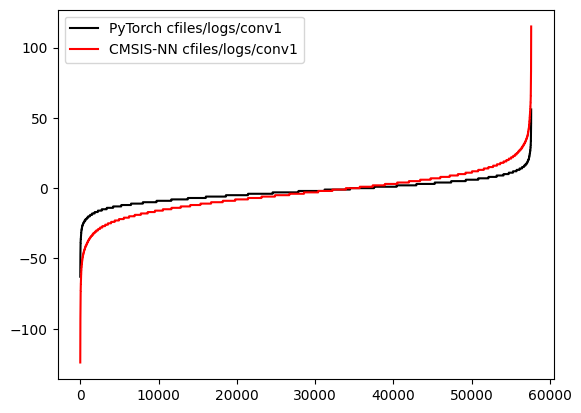

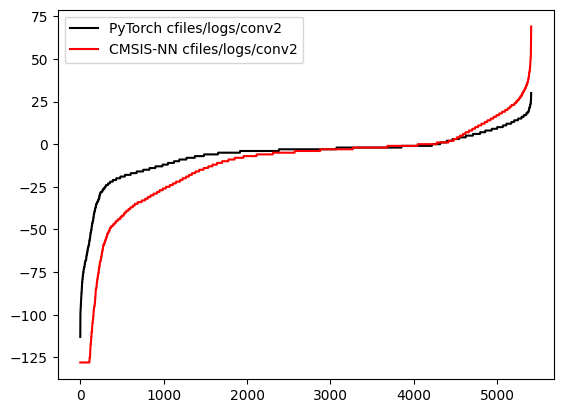

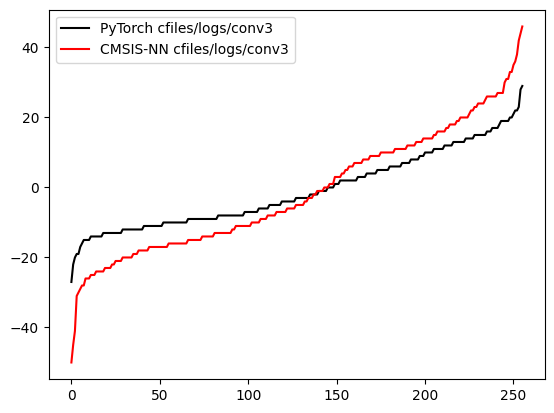

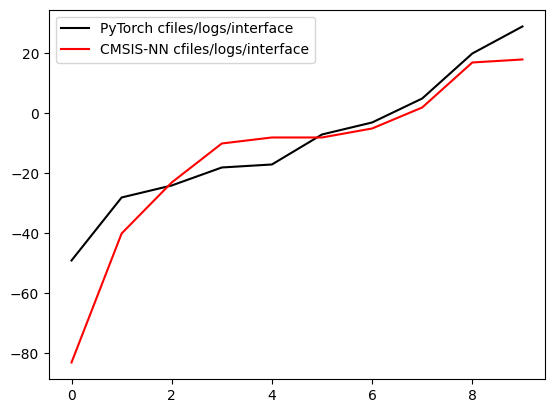

In [ ]:
input, label = next(iter(dataloaders["test"]))
cm_converter.sample_inference_checker(conversion_config.get("exec_path"), input, draw=True)

# Exercise

Now you can try to do different things:

1. build your own network and modify the main.c file to be able to run your own network in a MCU compatible format. Try to see if you can increase the network accuracy
2. Make an application that uses the main file for running inferences on images similar the ones found in CIFAR10?
3. How are we actually quantizing, can it be improved?